In [72]:
##Logistic Regression, XGBOOST, Random Forests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

In [73]:
## Dataframe details
df=pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [74]:
##Checking for null or duplicated values and dropping uncessary columns
df=df.drop(columns=["customerID"])
print(df.isnull().sum())
print("\n-----\n")
df=df.drop_duplicates()
print("Duplicated rows:", df.duplicated().sum())

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

-----

Duplicated rows: 0


In [75]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [76]:
#Encoding categorical variables
cat_var=df.select_dtypes(include=["object"]).columns
le=LabelEncoder()
for col in cat_var:
    df[col]=le.fit_transform(df[col])

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,2505,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1466,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,157,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1400,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,925,1


In [77]:
###checking for ourliers
num_var=df[["tenure", "MonthlyCharges", "TotalCharges"]]

z_score=np.abs(stats.zscore(num_var))
z_score_threshold=3

outlier_counts=(z_score>z_score_threshold).sum(axis=0)
print("Outliers per column: ")
print(outlier_counts)


Outliers per column: 
tenure            0
MonthlyCharges    0
TotalCharges      0
dtype: int64


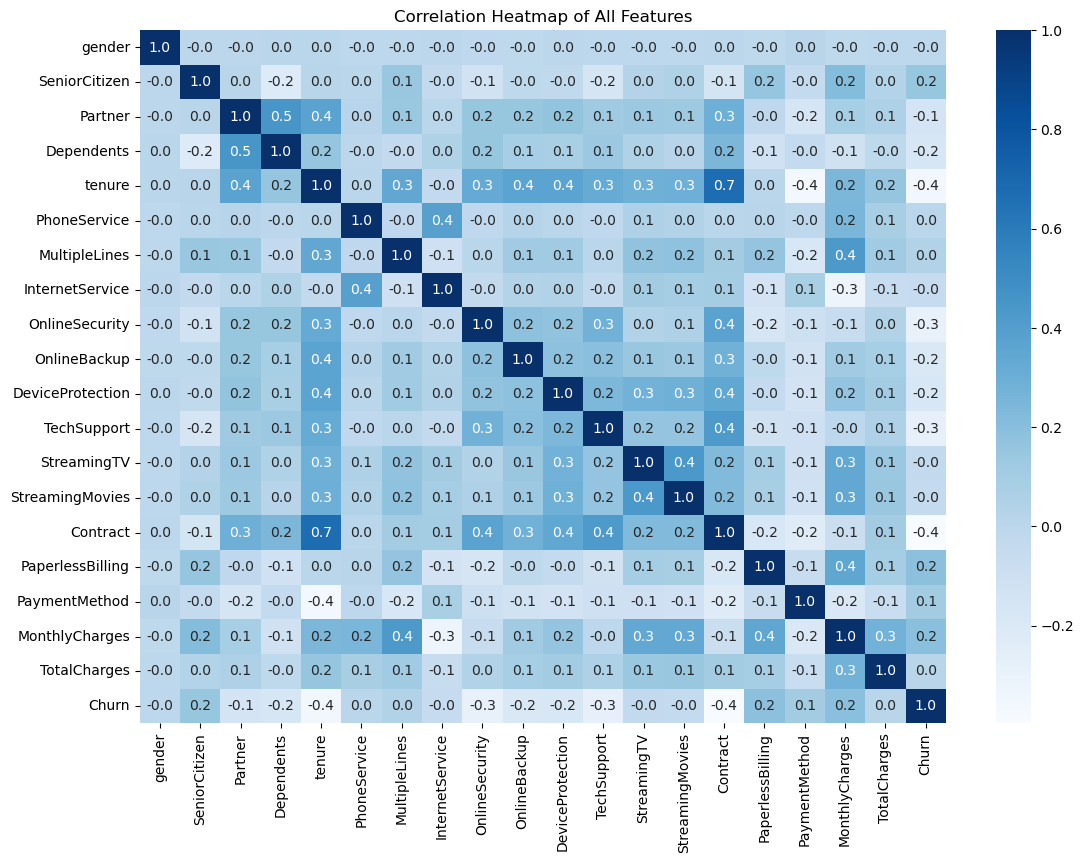

In [78]:
##correlation of features
plt.figure(figsize=(13,9))
sns.heatmap(df.corr(), annot=True, cmap=plt.cm.Blues, fmt=".1f")
plt.title("Correlation Heatmap of All Features")
plt.show()

In [79]:
#Splitting data
x=df.iloc[:,:19]
y=df.iloc[:,-1]


x_train, x_test,y_train, y_test=train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
print(x_train.head(),"\n---------------------")
print(y_train.head())

      gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
2629       1              0        0           0       2             1   
2650       0              0        0           0      15             1   
1418       1              0        1           1      67             1   
5774       1              0        0           0       5             1   
2425       1              0        0           0      26             1   

      MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
2629              0                1               0             0   
2650              2                1               2             0   
1418              2                1               0             2   
5774              0                0               0             2   
2425              0                2               1             1   

      DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
2629                 0            0            0       

In [80]:
##Standardizing continuous numeric columns:
num_var=["tenure", "MonthlyCharges", "TotalCharges"]

preprocess=ColumnTransformer(
    transformers=[
        ("cont", StandardScaler(), num_var)],
    remainder="passthrough")


x_train_processed=preprocess.fit_transform(x_train)
x_test_processed=preprocess.transform(x_test)

Churn
0    5164
1    1857
Name: count, dtype: int64


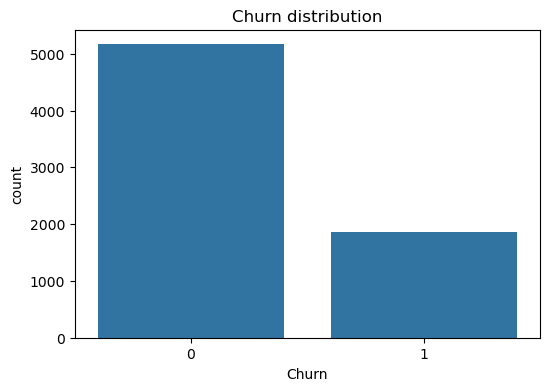

In [81]:
#identifying class imbalances
print(y.value_counts())

plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Churn")
plt.title("Churn distribution")
plt.show()

In [82]:
#handling imbalances
smote=SMOTE(k_neighbors=3, random_state=42)
x_resampled, y_resampled=smote.fit_resample(x_train_processed, y_train)

print(y_resampled.value_counts())

Churn
1    4131
0    4131
Name: count, dtype: int64


In [83]:
#Initializing StratifiedKFold CV, GridSearchCV and stacking classifier:
skf=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

base_models = [
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier()),
    ('xgb', XGBClassifier(
        eval_metric="logloss"
    ))
]

stack = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(),
    cv=skf
)

param_grid = {
    "lr__penalty": ["l2", None],
    "lr__C": [0.01, 0.1, 1, 10],
    "lr__solver": ["lbfgs", "saga"],
    "lr__max_iter": [100, 500, 1000],
    
    "rf__n_estimators": [100, 150, 200],
    "rf__max_depth": [None, 10, 20],
    "rf__max_features":["sqrt", "log2"],
    "rf__min_samples_split":[3, 4, 5],

    "xgb__learning_rate": [0.01, 0.1],
    "xgb__n_estimators":[100, 200],
    "xgb__max_depth": [3, 5],
    "xgb__subsample":[0.8, 1.0],
    "xgb__colsample_bytree": [0.8, 1.0]
}

grid = RandomizedSearchCV(stack, param_grid, return_train_score=True, cv=5, scoring='recall', n_jobs=-1, verbose=2)
grid.fit(x_resampled, y_resampled)
print(grid.best_params_)
print("Best CV Recall:", grid.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\Apostle\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Apostle\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Apostle\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Apostle\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Apostle\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Apostle\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting pena

{'xgb__subsample': 1.0, 'xgb__n_estimators': 200, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.01, 'xgb__colsample_bytree': 0.8, 'rf__n_estimators': 100, 'rf__min_samples_split': 5, 'rf__max_features': 'log2', 'rf__max_depth': 10, 'lr__solver': 'saga', 'lr__penalty': None, 'lr__max_iter': 1000, 'lr__C': 0.01}
Best CV Recall: 0.8540821136521339


In [84]:
##training and eval:

best_stack=grid.best_estimator_
y_pred_smote=best_stack.predict(x_test_processed)


acc_score=accuracy_score(y_test,y_pred_smote)
class_report=classification_report(y_test,y_pred_smote)
precision=precision_score(y_test,y_pred_smote)
recall=recall_score(y_test,y_pred_smote)
f1=f1_score(y_test,y_pred_smote)

print(f"Accuracy Score: {acc_score:.3f}\n")
print(f"Classification report: {class_report}\n")
print(f"Precision Score: {precision:.3f}\n")
print(f"Recall Score: {recall:.3f}\n")
print(f"F1 Score: {f1:.3f}\n")

Accuracy Score: 0.786

Classification report:               precision    recall  f1-score   support

           0       0.86      0.84      0.85      1033
           1       0.59      0.63      0.61       372

    accuracy                           0.79      1405
   macro avg       0.73      0.73      0.73      1405
weighted avg       0.79      0.79      0.79      1405


Precision Score: 0.590

Recall Score: 0.626

F1 Score: 0.608



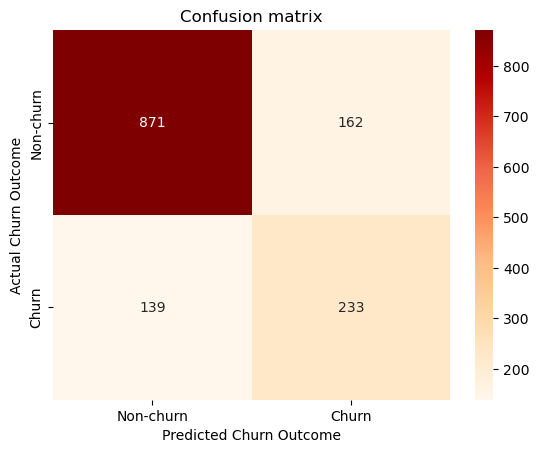

In [85]:
#confusion matrix
conf_mat=confusion_matrix(y_test,y_pred_smote)

sns.heatmap(conf_mat,
            annot=True,
            fmt="d",
            cmap="OrRd",
           xticklabels=["Non-churn","Churn"],
           yticklabels=["Non-churn","Churn"])
plt.title("Confusion matrix")
plt.xlabel("Predicted Churn Outcome")
plt.ylabel("Actual Churn Outcome")
plt.show()

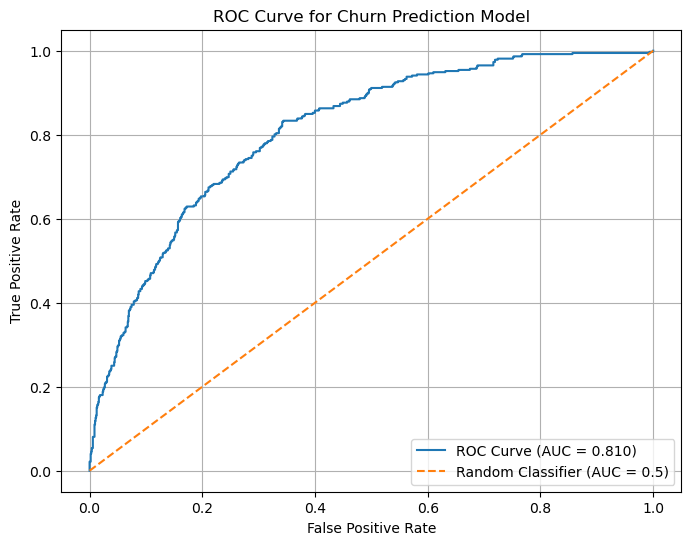

In [86]:
#ROC Curve
stack.fit(x_resampled, y_resampled)
y_proba = stack.predict_proba(x_test_processed)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random Classifier (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Churn Prediction Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

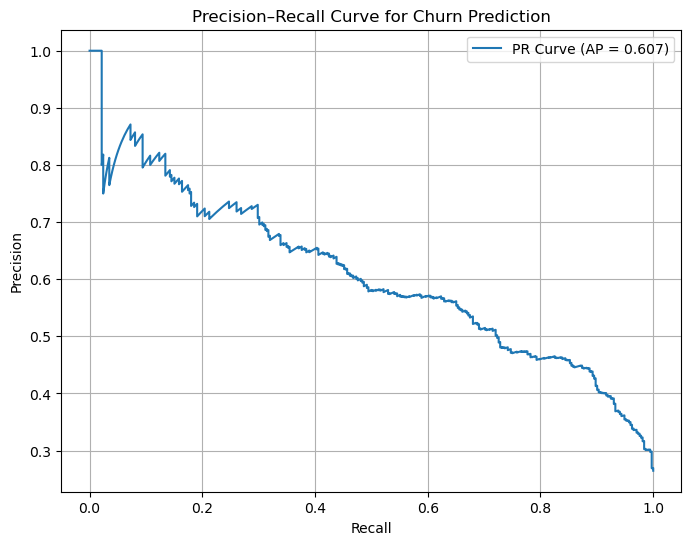

In [87]:
#Precision-Recall curve
stack.fit(x_resampled, y_resampled)
y_proba = stack.predict_proba(x_test_processed)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
ap_score = average_precision_score(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f"PR Curve (AP = {ap_score:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve for Churn Prediction")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

C:\Users\Apostle\AppData\Local\Temp\ipykernel_11476\2410608712.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(10), x="Importance", y="Feature", palette=cols)
C:\Users\Apostle\AppData\Local\Temp\ipykernel_11476\2410608712.py:12: UserWarning: The palette list has more values (19) than needed (10), which may not be intended.
  sns.barplot(data=importance_df.head(10), x="Importance", y="Feature", palette=cols)


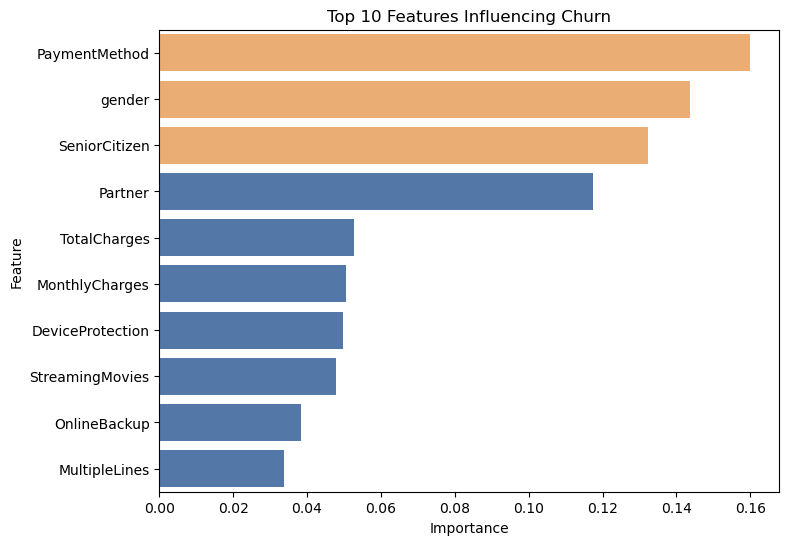

In [88]:
#Feature importance h-bar
importances = stack.named_estimators_['rf'].feature_importances_

cols=["#fdae61" if y >= 0.06 else "#4575b4" for y in importances]
feature_names = x_train.columns
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=importance_df.head(10), x="Importance", y="Feature", palette=cols)
plt.title("Top 10 Features Influencing Churn")
plt.show()